### Abstract

This notebook is intended to build a recommendation system from the dataset of goodbooks-10k. This notebook is inspired by [the blog](https://towardsdatascience.com/building-a-book-recommendation-system-using-keras-1fba34180699).

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

warnings.filterwarnings('ignore')
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300

In [2]:
!pip freeze | grep h5


You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
h5py==2.9.0


In [3]:
dataset = pd.read_csv('data/goodbooks-10k/ratings.csv')

print(len(dataset))

981756


In [4]:
dataset.head()


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [5]:
dataset.shape


(981756, 3)

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [7]:
train.head()


,book_id,user_id,rating
341848,3423,4608,2
964349,9811,36373,5
645459,6485,2957,4
74960,750,42400,3
358670,3591,36886,5


In [39]:
train.describe()

,book_id,user_id,rating
count,785404.000000,785404.000000,785404.000000
mean,4943.971010,25634.469790,3.857047
std,2873.419846,15232.240666,0.983540
min,1.000000,1.000000,1.000000
25%,2458.000000,12373.000000,3.000000
50%,4922.000000,25120.000000,4.000000
75%,7415.000000,38605.000000,5.000000
max,10000.000000,53424.000000,5.000000


In [8]:
test.head()


,book_id,user_id,rating
646451,6495,19643,5
614851,6175,8563,4
974393,9920,52110,3
21471,215,33864,5
272540,2728,16587,3


In [9]:
n_users = len(dataset.user_id.unique())
n_users

53424

In [10]:
n_books = len(dataset.book_id.unique())
n_books

10000

In [11]:
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

In [12]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Book-Input (InputLayer)          (None, 1)             0                                            
____________________________________________________________________________________________________
User-Input (InputLayer)          (None, 1)             0                                            
____________________________________________________________________________________________________
Book-Embedding (Embedding)       (None, 1, 5)          50005       Book-Input[0][0]                 
____________________________________________________________________________________________________
User-Embedding (Embedding)       (None, 1, 5)          267125      User-Input[0][0]                 
___________________________________________________________________________________________

Epoch 1/5
785404/785404 [==============================] - 67s - loss: 4.4126    
Epoch 2/5
785404/785404 [==============================] - 57s - loss: 1.7988    
Epoch 3/5
785404/785404 [==============================] - 56s - loss: 1.2058    
Epoch 4/5
785404/785404 [==============================] - 68s - loss: 0.9665    
Epoch 5/5
785404/785404 [==============================] - 69s - loss: 0.8422    


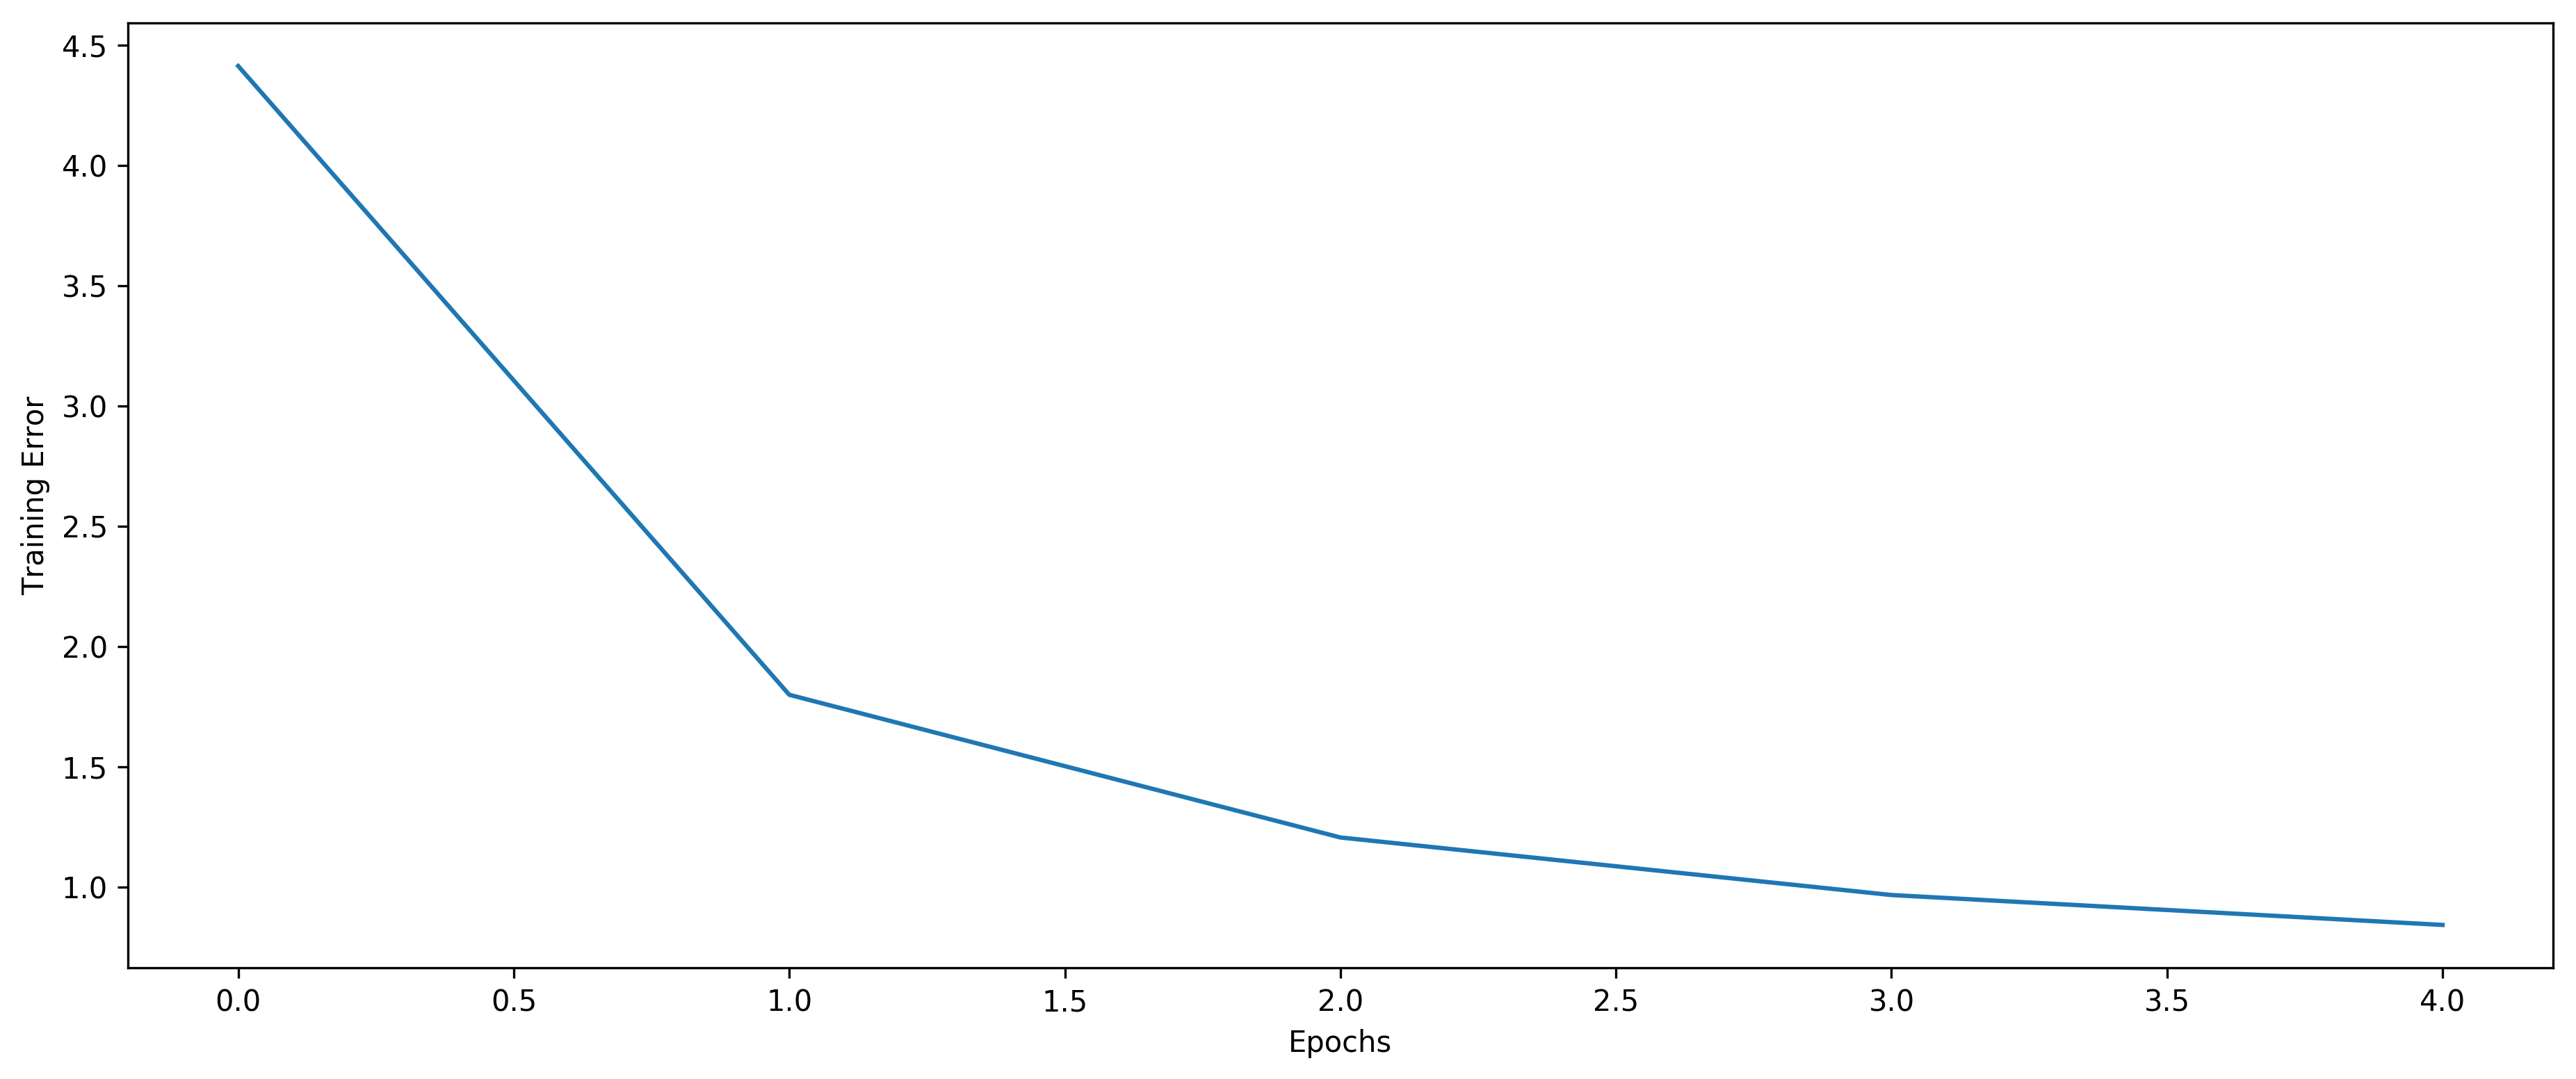

In [17]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [20]:
model.evaluate([test.user_id, test.book_id], test.rating, verbose = 1)


196352/196352 [==============================] - 7s     


1.0886894626958197

In [23]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

for i in range(0, 10):
    print(predictions[i], test.rating.iloc[i])

(array([4.8131003], dtype=float32), 5)
(array([3.6526728], dtype=float32), 4)
(array([3.381619], dtype=float32), 3)
(array([4.3959727], dtype=float32), 5)
(array([3.5701256], dtype=float32), 3)
(array([3.8350134], dtype=float32), 3)
(array([4.1525836], dtype=float32), 3)
(array([4.9460154], dtype=float32), 4)
(array([4.218849], dtype=float32), 3)
(array([4.5033236], dtype=float32), 5)


### Visualizing Embeddings


In [26]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

book_em_weights[:5]

array([[ 0.03018347,  0.0441296 , -0.01850783, -0.04355035, -0.04597021],
       [ 1.2068563 ,  1.5798439 , -1.5405461 ,  1.4667912 ,  1.5167083 ],
       [ 1.1507667 ,  1.6068218 , -1.500695  ,  1.4910469 ,  1.4942037 ],
       [ 0.8722425 ,  0.9196312 , -1.1681281 ,  1.1025422 ,  1.1282539 ],
       [ 1.4922897 ,  1.7249038 , -1.5235978 ,  1.2612894 ,  1.4218589 ]],
      dtype=float32)

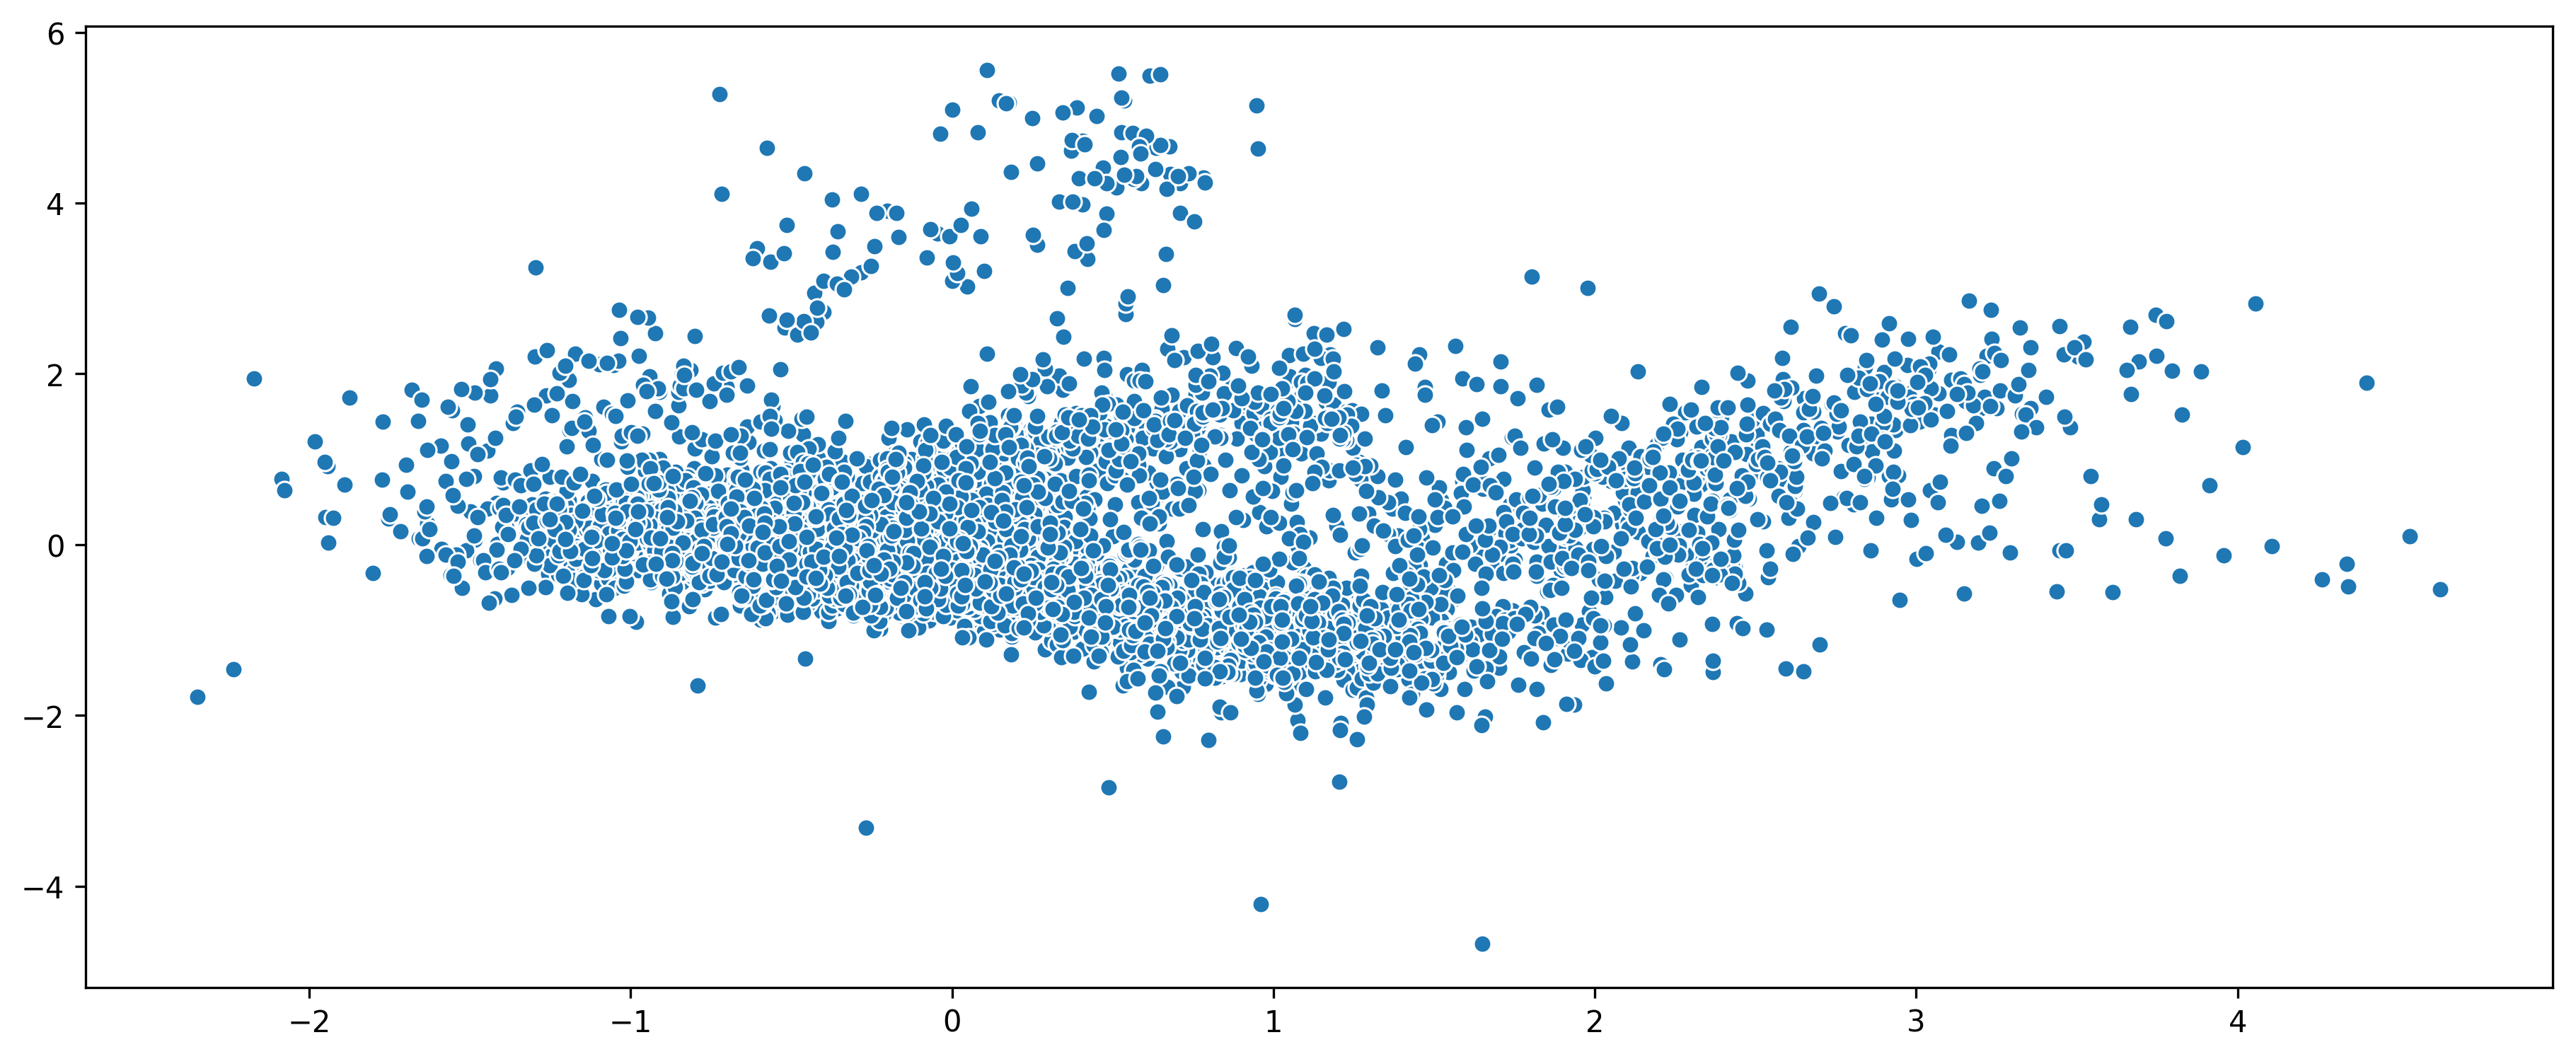

In [28]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
_ = sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [29]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0000001

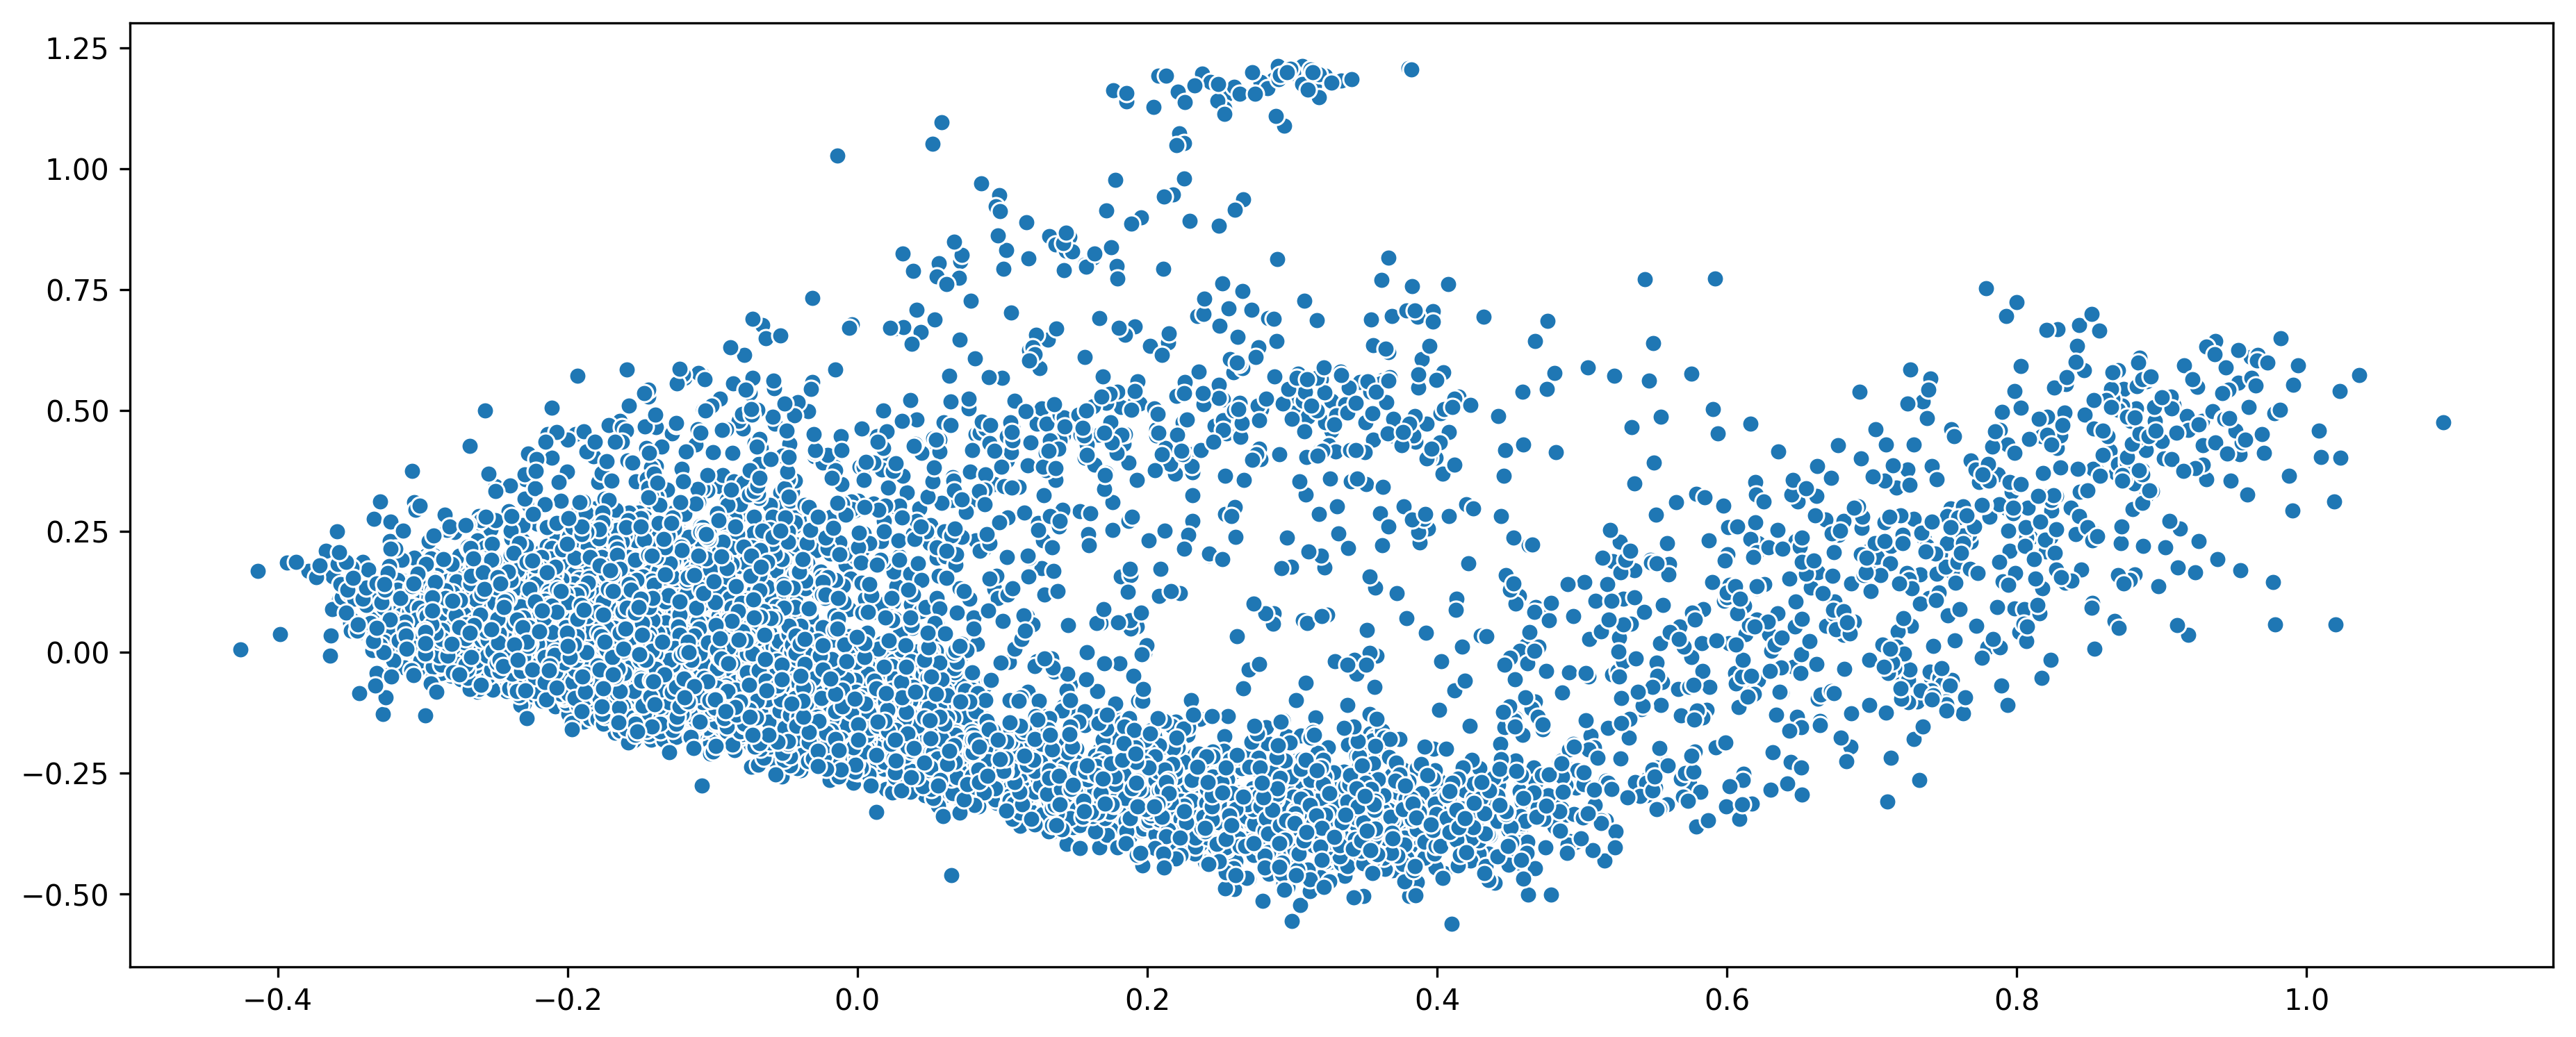

In [30]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
_ = sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.009s...
[t-SNE] Computed neighbors for 10001 samples in 1.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.028350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.856598
[t-SNE] Er

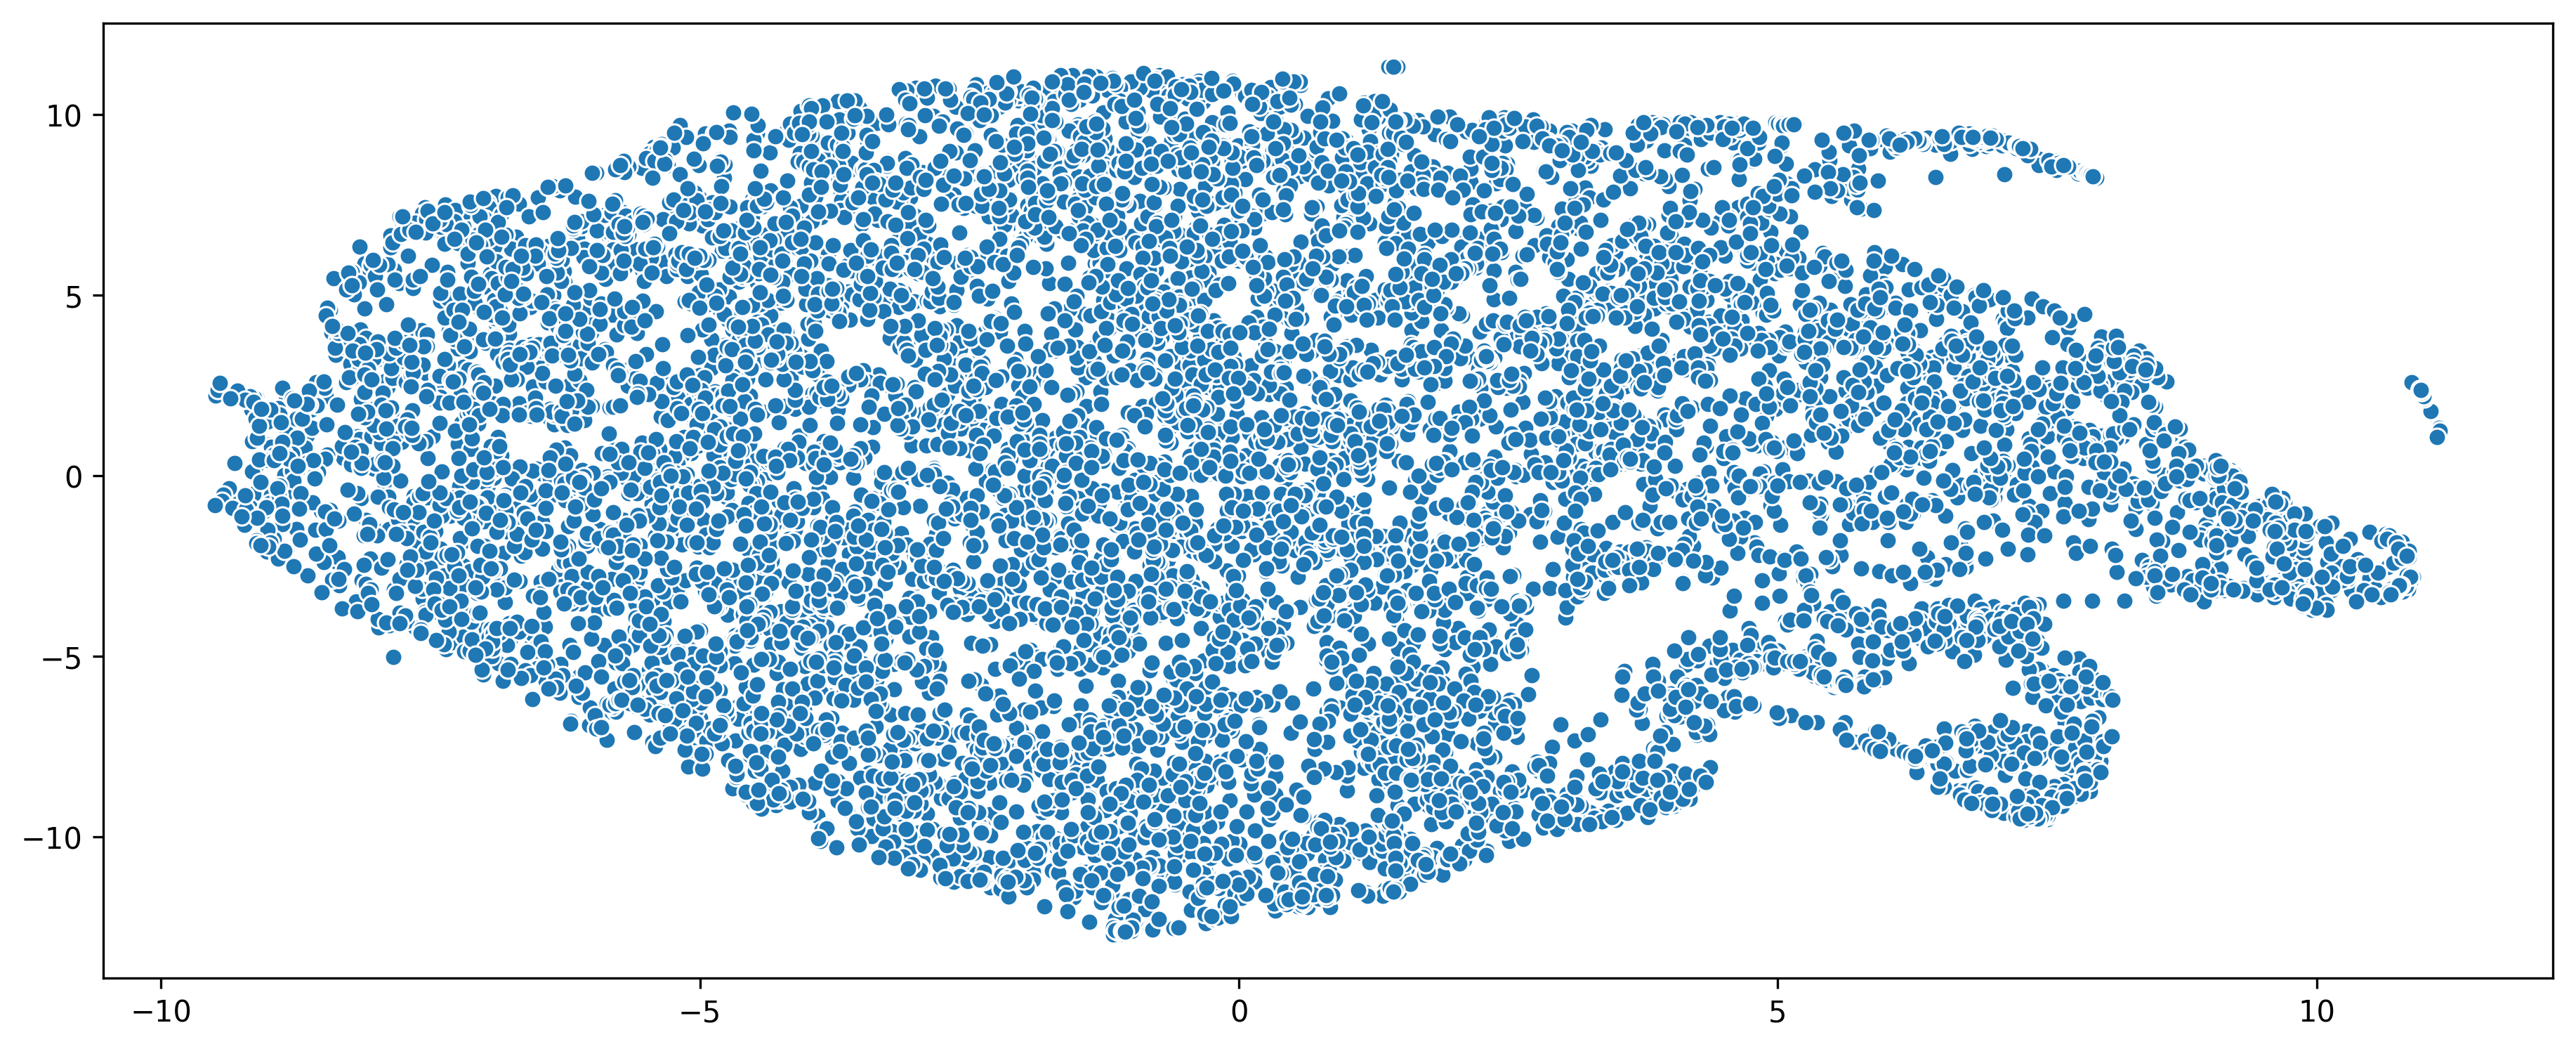

In [33]:
_ = sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

### Make Recommendations

In [34]:
# Creating dataset for making recommendations for the first user
book_data = np.array(list(set(dataset.book_id)))
book_data[:5]

array([1, 2, 3, 4, 5])

In [36]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [38]:
predictions = model.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([8232, 8998, 8547, 7660, 9872])

In [40]:
# print predicted scores
predictions[recommended_book_ids]

array([4.716221 , 4.706584 , 4.641747 , 4.6372256, 4.630868 ],
      dtype=float32)

In [41]:
books = pd.read_csv('data/goodbooks-10k/books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [43]:
books[books['id'].isin(recommended_book_ids)].T

,7659,8231,8546,8997,9871
id,7660,8232,8547,8998,9872
book_id,21330,10395,1833852,292740,24480276
best_book_id,21330,10395,1833852,292740,24480276
work_id,2910,13106,1833795,2457130,44074400
books_count,15,31,48,37,45
isbn,1401204864,60731427,385521723,2266071289,NaN
isbn13,9.7814e+12,9.78006e+12,9.78039e+12,9.78227e+12,9.78147e+12
authors,"Bill Willingham, Mark Buckingham, Steve Leialo...",Franklin Foer,Steve Toltz,Lorenzo Carcaterra,Laura Barnett
original_publication_year,2005,2004,2008,1995,2015
original_title,"Fables, Volume 5: The Mean Seasons",How Soccer Explains the World: An Unlikely The...,A Fraction of the Whole,Sleepers,The Versions of Us
